# Debugging Assignment — Employee Attrition Prediction (BROKEN VERSION)

Fixed 

In [5]:
# Cell: imports & basic config
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report, confusion_matrix)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42


In [6]:
#Load data and sanity checks
# df = pd.read_csv("debug_dataset.csv")
df = pd.read_csv("../data/attrition.csv")
print("shape:", df.shape)
display(df.head())
display(df.info())
print("\nMissing values (top 20):")
display(df.isna().sum().sort_values(ascending=False).head(20))

# target sanity check
assert 'attrition' in df.columns, "No 'attrition' column found"
print("Target distribution:")
print(df['attrition'].value_counts(normalize=True))


shape: (300, 11)


,age,gender,education,department,job_role,monthly_income,years_at_company,promotions,overtime,performance_rating,attrition
0,50,Female,Post-Graduate,IT,Lead,102565,9,0,No,1,0
1,36,Female,PhD,Sales,Lead,49402,2,0,Yes,2,0
2,29,Female,Graduate,HR,Executive,24263,7,1,No,1,0
3,42,Male,Graduate,HR,Executive,116523,7,3,Yes,4,0
4,40,Female,PhD,HR,Manager,66828,1,1,Yes,3,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   age                 300 non-null    int64 
 1   gender              300 non-null    object
 2   education           300 non-null    object
 3   department          300 non-null    object
 4   job_role            300 non-null    object
 5   monthly_income      300 non-null    int64 
 6   years_at_company    300 non-null    int64 
 7   promotions          300 non-null    int64 
 8   overtime            300 non-null    object
 9   performance_rating  300 non-null    int64 
 10  attrition           300 non-null    int64 
dtypes: int64(6), object(5)
memory usage: 25.9+ KB


None


Missing values (top 20):


age                   0
gender                0
education             0
department            0
job_role              0
monthly_income        0
years_at_company      0
promotions            0
overtime              0
performance_rating    0
attrition             0
dtype: int64

Target distribution:
attrition
0    0.77
1    0.23
Name: proportion, dtype: float64


In [7]:
# Cell: quick leakage detection (exact-match and high-correlation checks)
def find_obvious_leaks(df, target='attrition', corr_threshold=0.98):
    leaks = {}
    # 1) exact duplicates of target (identical columns)
    identical = [c for c in df.columns if c!=target and df[c].equals(df[target])]
    leaks['identical_to_target'] = identical
    # 2) columns with suspicious names
    suspicious = [c for c in df.columns if any(k in c.lower() for k in ['target','label','outcome','after','post','leak','result','final'])]
    leaks['suspicious_names'] = suspicious
    # 3) numeric columns highly correlated with target
    num = df.select_dtypes(include=[np.number])
    if target in num.columns:
        corr = num.corr()[target].abs().sort_values(ascending=False)
        high_corr = corr[corr>=corr_threshold].index.tolist()
        high_corr = [c for c in high_corr if c!=target]
        leaks['high_corr'] = high_corr
    else:
        leaks['high_corr'] = []
    return leaks

leaks = find_obvious_leaks(df, 'attrition')
leaks


{'identical_to_target': [], 'suspicious_names': [], 'high_corr': []}

In [9]:
# Cell: remove obvious leakage columns
leak_cols = leaks['identical_to_target'] + leaks['suspicious_names'] + leaks['high_corr']
leak_cols = list(dict.fromkeys(leak_cols))  # unique preserve order
print("Dropping suspicious/leaky columns:", leak_cols)
df_clean = df.drop(columns=[c for c in leak_cols if c in df.columns])
print("New shape:", df_clean.shape)


Dropping suspicious/leaky columns: []
New shape: (300, 11)


In [10]:
# Cell: analyze missingness & set sensible imputers
missing = df_clean.isna().mean().sort_values(ascending=False)
display(missing[missing>0].head(30))

# Strategy:
# - numeric -> median
# - categorical -> 'Missing' sentinel

num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c!='attrition']  # exclude target
cat_cols = [c for c in df_clean.columns if c not in num_cols + ['attrition']]

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)


Series([], dtype: float64)

Numeric cols: ['age', 'monthly_income', 'years_at_company', 'promotions', 'performance_rating']
Categorical cols: ['gender', 'education', 'department', 'job_role', 'overtime']


In [12]:
# Cell: ColumnTransformer + Pipeline (do NOT fit yet)
num_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
], remainder='drop')

clf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, class_weight='balanced')

pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', clf)
])
print("Pipeline created (not fitted).")


Pipeline created (not fitted).


In [13]:
# Cell: train/test split (stratified)
X = df_clean.drop(columns=['attrition'])
y = df_clean['attrition'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape)
print("Train class balance:", y_train.value_counts(normalize=True).to_dict())
print("Test class balance:", y_test.value_counts(normalize=True).to_dict())


Train/test shapes: (240, 10) (60, 10)
Train class balance: {0: 0.7708333333333334, 1: 0.22916666666666666}
Test class balance: {0: 0.7666666666666667, 1: 0.23333333333333334}


In [14]:
# Cell: cross-validate pipeline on training data (no leakage)
scoring = ['accuracy','precision','recall','f1','roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_res = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
import numpy as np
cv_summary = {k: (cv_res[f'test_{k}'].mean(), cv_res[f'test_{k}'].std()) for k in scoring}
cv_summary


{'accuracy': (np.float64(0.7625000000000001),
  np.float64(0.016666666666666698)),
 'precision': (np.float64(0.0), np.float64(0.0)),
 'recall': (np.float64(0.0), np.float64(0.0)),
 'f1': (np.float64(0.0), np.float64(0.0)),
 'roc_auc': (np.float64(0.386977886977887), np.float64(0.04472149453810936))}

In [15]:
# Cell: cross-validate pipeline on training data (no leakage)
scoring = ['accuracy','precision','recall','f1','roc_auc']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_res = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False, n_jobs=-1)
import numpy as np
cv_summary = {k: (cv_res[f'test_{k}'].mean(), cv_res[f'test_{k}'].std()) for k in scoring}
cv_summary


{'accuracy': (np.float64(0.7625000000000001),
  np.float64(0.016666666666666698)),
 'precision': (np.float64(0.0), np.float64(0.0)),
 'recall': (np.float64(0.0), np.float64(0.0)),
 'f1': (np.float64(0.0), np.float64(0.0)),
 'roc_auc': (np.float64(0.386977886977887), np.float64(0.04472149453810936))}

In [16]:
# Cell: fit final model and evaluate on holdout
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba)
}
print("Holdout metrics (clean pipeline):")
print(metrics)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


Holdout metrics (clean pipeline):
{'accuracy': 0.7666666666666667, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'roc_auc': 0.517080745341615}

Classification report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        46
           1       0.00      0.00      0.00        14

    accuracy                           0.77        60
   macro avg       0.38      0.50      0.43        60
weighted avg       0.59      0.77      0.67        60


Confusion matrix:
 [[46  0]
 [14  0]]


In [19]:
# OPTION A: factorize categorical columns before scaling (quick hack)
df_leaky = df.copy()
df_leaky['attrition_copy'] = df_leaky['attrition']   # intentional leak

# naive impute then factorize non-numeric columns to get numeric matrix
X_leaky = df_leaky.drop(columns=['attrition'])
y_leaky = df_leaky['attrition'].astype(int)

# fill missing quickly (intentionally poor)
X_leaky_filled = X_leaky.fillna(0)

# factorize all object/categorical columns to numeric codes
X_leaky_enc = X_leaky_filled.copy()
for c in X_leaky_enc.columns:
    if X_leaky_enc[c].dtype == 'O' or X_leaky_enc[c].dtype.name.startswith('category'):
        X_leaky_enc[c] = pd.factorize(X_leaky_enc[c])[0]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_leaky_scaled = scaler.fit_transform(X_leaky_enc)   # now all numeric

# proceed as before (LEAKY: split AFTER scaling)
from sklearn.model_selection import train_test_split
X_tr_l, X_te_l, y_tr_l, y_te_l = train_test_split(X_leaky_scaled, y_leaky,
                                                  test_size=0.2, random_state=RANDOM_STATE, stratify=y_leaky)

from sklearn.ensemble import RandomForestClassifier
rf_leaky = RandomForestClassifier(n_estimators=500, random_state=RANDOM_STATE)
rf_leaky.fit(X_tr_l, y_tr_l)
y_pred_l = rf_leaky.predict(X_te_l)
y_proba_l = rf_leaky.predict_proba(X_te_l)[:,1]

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
leaky_metrics = {
    'accuracy': accuracy_score(y_te_l, y_pred_l),
    'precision': precision_score(y_te_l, y_pred_l, zero_division=0),
    'recall': recall_score(y_te_l, y_pred_l, zero_division=0),
    'f1': f1_score(y_te_l, y_pred_l, zero_division=0),
    'roc_auc': roc_auc_score(y_te_l, y_proba_l)
}
print("Leaky pipeline (inflated) metrics:")
print(leaky_metrics)


Leaky pipeline (inflated) metrics:
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': 1.0}


,Leaky,Clean
accuracy,1.0,0.766667
precision,1.0,0.000000
recall,1.0,0.000000
f1,1.0,0.000000
roc_auc,1.0,0.517081


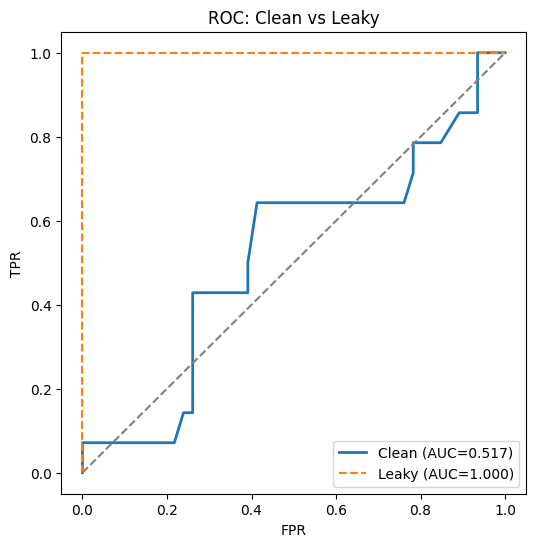

In [20]:
#compare leaky vs clean
comparison = pd.DataFrame({'Leaky': leaky_metrics, 'Clean': metrics})
display(comparison)

# Plot ROC curves for both (if leaky predictions available)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(6,6))
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"Clean (AUC={auc(fpr,tpr):.3f})", linewidth=2)
fpr_l, tpr_l, _ = roc_curve(y_te_l, y_proba_l)
plt.plot(fpr_l, tpr_l, label=f"Leaky (AUC={auc(fpr_l,tpr_l):.3f})", linestyle='--')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC: Clean vs Leaky'); plt.legend(); plt.show()


In [21]:

from sklearn.metrics import roc_auc_score

def leakage_detection_report(df, target='attrition', auc_threshold=0.98, corr_threshold=0.98):
    report = {}
    report['identical'] = [c for c in df.columns if c!=target and df[c].equals(df[target])]
    # per-feature AUC (simple test)
    auc_hits = []
    for c in df.columns:
        if c==target: continue
        try:
            x = df[c].copy()
            if x.dtype == 'O' or x.dtype.name.startswith('category'):
                x = pd.Series(pd.factorize(x)[0], index=x.index)
            mask = (~x.isna()) & (~df[target].isna())
            if mask.sum() < 50: 
                continue
            auc = roc_auc_score(df.loc[mask, target], x.loc[mask])
            if auc >= auc_threshold or auc <= (1-auc_threshold):
                auc_hits.append((c, auc))
        except Exception:
            continue
    report['high_auc_features'] = auc_hits
    # correlations for numeric
    num = df.select_dtypes(include=[np.number])
    if target in num:
        corr = num.corr()[target].abs().sort_values(ascending=False)
        report['high_corr'] = corr[corr>=corr_threshold].index.tolist()
    else:
        report['high_corr'] = []
    return report

report = leakage_detection_report(df, 'attrition')
report


{'identical': [], 'high_auc_features': [], 'high_corr': ['attrition']}

## Final pipeline 

In [22]:
# Cell: save pipeline + metrics
os.makedirs('artifacts', exist_ok=True)
joblib.dump(pipeline, 'artifacts/clean_pipeline.joblib')
joblib.dump({'clean_metrics': metrics, 'leaky_metrics': leaky_metrics}, 'artifacts/metrics_summary.joblib')
print("Saved clean pipeline and metric summary to artifacts/")


Saved clean pipeline and metric summary to artifacts/
